<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-no-supervisado/blob/main/Aprendizaje_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje no supervizado: Aplicaciones al clustering en Industiras

## 0. Cargar Bibliotecas

In [ ]:
!pip install -U yellowbrick

     |████████████████████████████████| 266kB 7.6MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler  #estandarizar varibles
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from google.colab import files  #funcion para subir archivo csv a google colab

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Subir archivo de datos

files.upload()

## Leer datos 

In [ ]:
df = pd.read_csv('train_input_2yaM34J.csv',
                    index_col=['ID'], parse_dates=['Date'])
df


,Date,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,
0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0
1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0
2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0
3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0
4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...
7995,2018-02-18 17:30:00,20.5,26.0,18.4,390.0,5.0
7996,2018-02-18 18:00:00,20.4,26.0,18.3,383.0,2.0
7997,2018-02-18 18:30:00,20.3,26.0,18.2,377.0,1.0


# Exploración de datos

In [ ]:
datos = df.copy()
datos.drop(['Date'],axis= 1, inplace=True)
datos.head(3)

,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,22.7,56.0,25.7,534.0,1.0
1,22.8,55.0,25.7,506.0,1.0
2,22.9,55.0,25.9,577.0,1.0


In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  8000 non-null   float64
 1   Humidity     8000 non-null   float64
 2   Humex        8000 non-null   float64
 3   CO2          8000 non-null   float64
 4   Bright       8000 non-null   float64
dtypes: float64(5)
memory usage: 375.0 KB


## ¿Existen casos faltantes?




En caso afirmativo:
1. Remover renglones con valores faltantes

  `dropna()`
2. Imputar valores faltante con el promedio, la mediana o la moda de la columna.

  `fillna(df.columna.mean()`
3. Valor estimado mediante otro modelo de aprendizaje de máquina.

In [ ]:
datos.isna().sum()

Temperature    0
Humidity       0
Humex          0
CO2            0
Bright         0
dtype: int64

## Distribución y correlación entre variables

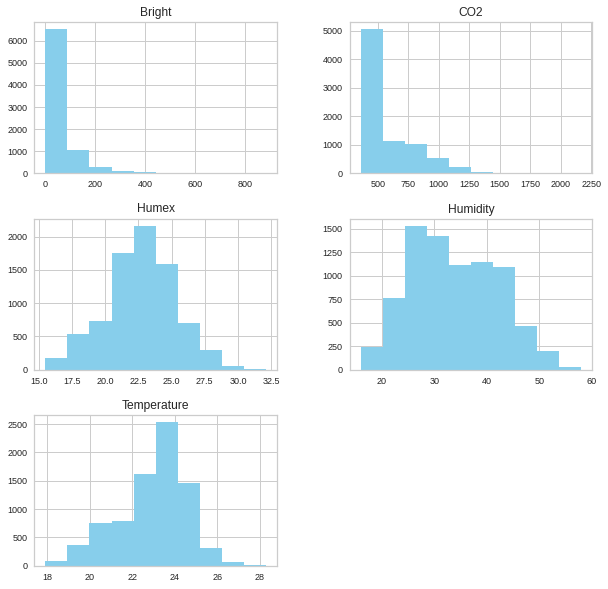

In [ ]:
datos.hist(figsize = (10,10), xlabelsize=9, ylabelsize=9,
                               color='skyblue')
plt.show()

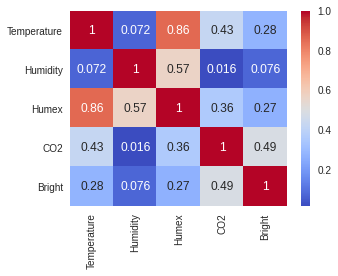

In [ ]:
def correlacion(dataframe, grafica = True):
    corr=dataframe.corr()                #creamos la matriz de correlación
    fig = plt.figure(figsize = (5, 4))
    if grafica == True:
        sns.heatmap(corr, cmap="coolwarm", annot=True, square=False)
        fig.tight_layout()
    return corr
correlaciones = correlacion(datos)

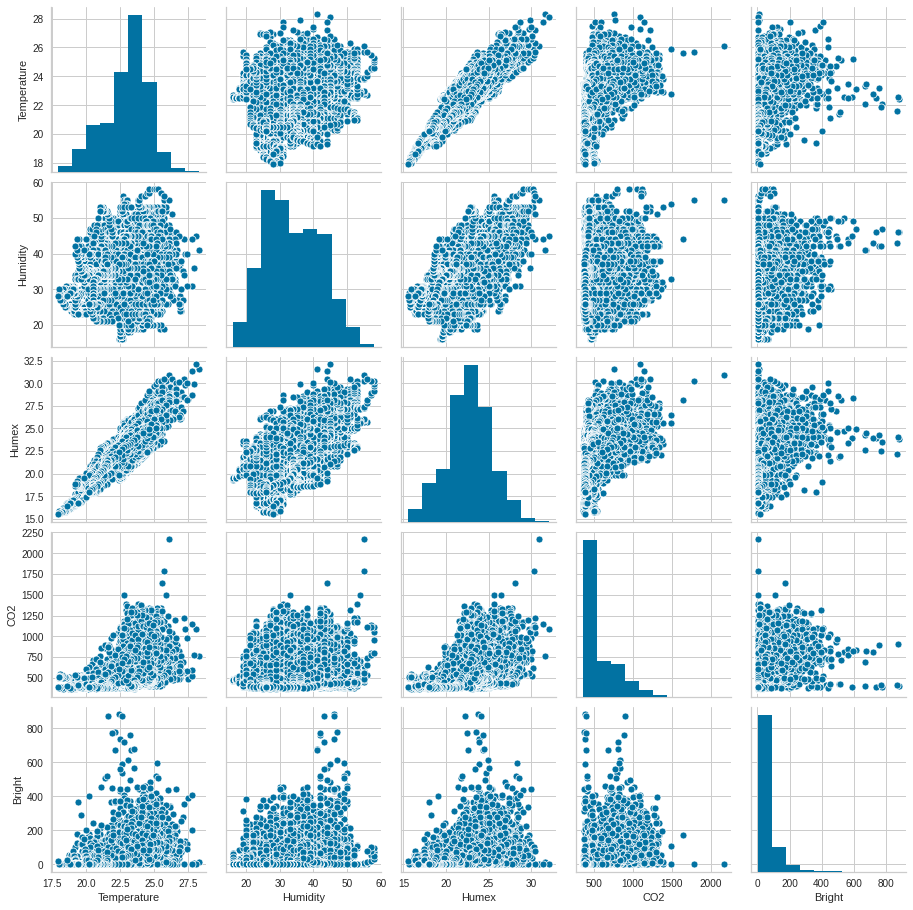

In [ ]:
g = sns.pairplot(datos, palette ='Dark2')

plt.show()

## Unificar escalas de medición de cada variable

In [ ]:
datos_escalados = datos.copy()
columnas = datos.columns

escala = MinMaxScaler()


datos_escalados[columnas] = escala.fit_transform(datos[columnas])
datos_escalados


,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,0.461538,0.952381,0.614458,0.095739,0.000000
1,0.471154,0.928571,0.614458,0.080243,0.000000
2,0.480769,0.928571,0.626506,0.119535,0.000000
3,0.490385,0.928571,0.638554,0.148866,0.000000
4,0.490385,0.928571,0.638554,0.156060,0.000000
...,...,...,...,...,...
7995,0.250000,0.238095,0.174699,0.016049,0.004540
7996,0.240385,0.238095,0.168675,0.012175,0.001135
7997,0.230769,0.238095,0.162651,0.008854,0.000000


# Selección del número de clústers 

### Elbow Method

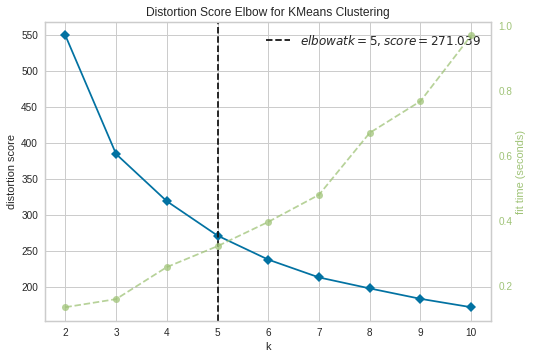

In [ ]:

codo = KElbowVisualizer(KMeans(random_state=3))
codo.fit(datos_escalados)
codo.poof()

### Coeficiente de Silhouette

El coeficiente de Silhouette evalúa la cercania entre puntos de un mismo cluster al mismo tiempo que la distancia a los clusters vecinos.
 
El coeficiente de Silhouette oscila entre -1 y 1 donde 1 indica un clúster de alta densidad y -1 que no existe densidad alguna.

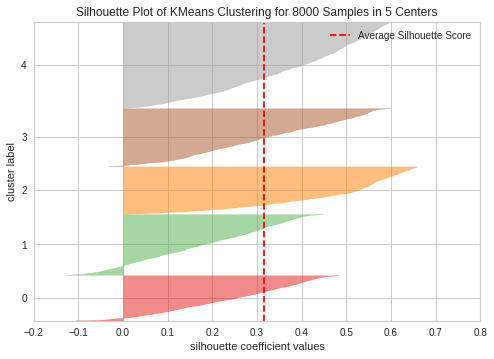

In [ ]:
model = KMeans(5)
graf_sil = SilhouetteVisualizer(model)
graf_sil.fit(datos_escalados)
graf_sil.poof()

# K means

In [ ]:
model = KMeans(n_clusters = 5, random_state=37).fit(datos_escalados)
clusters = model.predict(datos_escalados)

In [ ]:
datos.insert(0, 'cluster', clusters+1)
datos

,cluster,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,
0,1,22.7,56.0,25.7,534.0,1.0
1,1,22.8,55.0,25.7,506.0,1.0
2,1,22.9,55.0,25.9,577.0,1.0
3,1,23.0,55.0,26.1,630.0,1.0
4,1,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...
7995,2,20.5,26.0,18.4,390.0,5.0
7996,2,20.4,26.0,18.3,383.0,2.0
7997,2,20.3,26.0,18.2,377.0,1.0


In [ ]:
datos.cluster.value_counts().sort_index()

1    1487
2    1325
3    2319
4    1195
5    1674
Name: cluster, dtype: int64

In [ ]:
%matplotlib inline

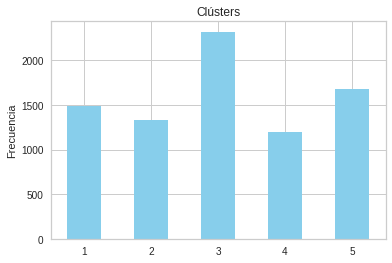

In [ ]:
g = datos.cluster.value_counts().sort_index().plot(kind='bar', 
                                                rot=0, 
                                                color='skyblue',
                                                )
g.set(ylabel='Frecuencia', title='Clústers')
plt.show()

In [ ]:
datos_escalados.insert(0, 'cluster', clusters+1)


In [ ]:
datos_escalados.cluster = datos_escalados.cluster.astype(str)

In [ ]:
fig = px.scatter_3d(datos_escalados, x='Humidity', y='Bright', z='Humex',
                    color='cluster',
                    title="3D Scatter Plot", size='CO2')

fig.show()

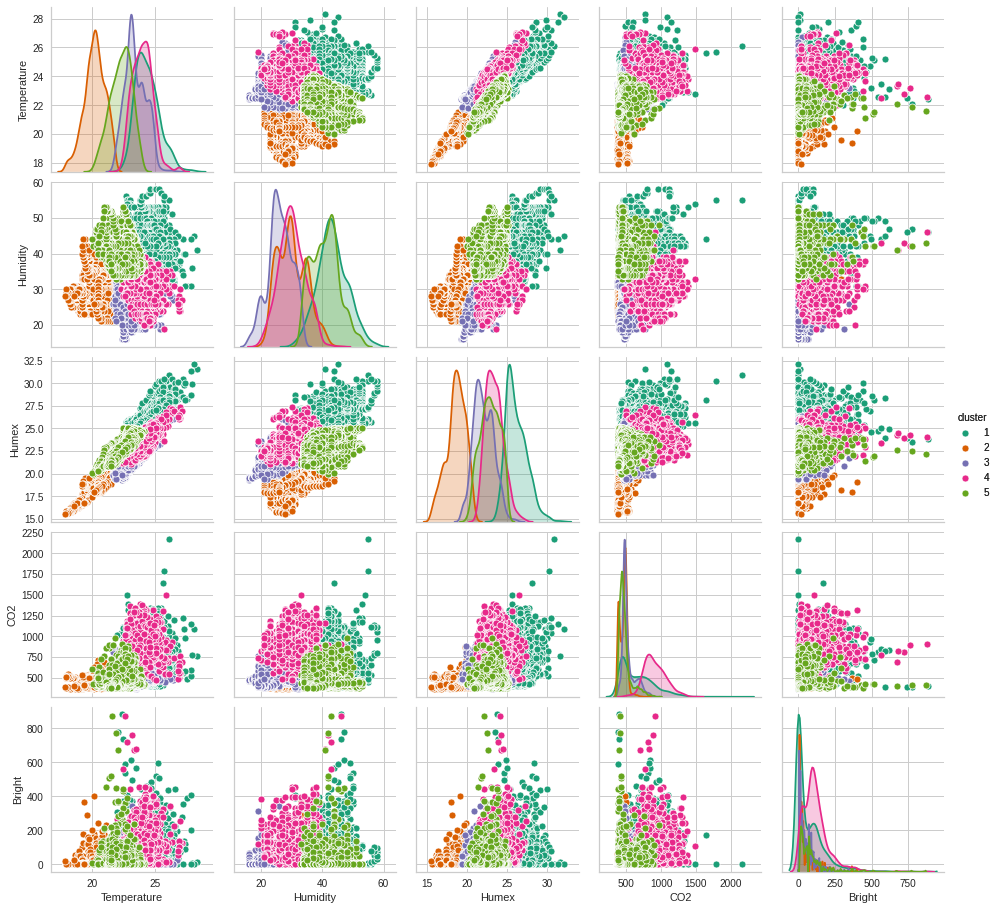

In [ ]:
mediciones = ['cluster', 'Temperature', 'Humidity', 'Humex', 'CO2', 'Bright']

sns.set_palette('Dark2')
g = sns.pairplot(datos[mediciones], hue='cluster')
g.add_legend()
plt.show()